In [30]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\PYWORK\NHITS


In [31]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [32]:
cutoff_date = '2022-04-30' ## len = 65, 월별 마지막 일자 잘 맞춰 줘야 함
test_period = 8 ## 예측 기간 (월)
corr_rate = 0.8 ## Lag corr rate

## <원 data set>

In [33]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift

In [34]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(10,13):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: total: 49.7 s
Wall time: 4min


In [35]:
raw_y_set_shifted_merged

,date,y,y_11,y_12,y_13,y2,y2_11,y2_12,y2_13,Baltic Dry Index (BDI),...,Allkem Limited (AKE.AX)_price_Low_12,Allkem Limited (AKE.AX)_price_Low_13,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Close_11,Allkem Limited (AKE.AX)_price_Close_12,Allkem Limited (AKE.AX)_price_Close_13,Allkem Limited (AKE.AX)_price_Adj Close,Allkem Limited (AKE.AX)_price_Adj Close_11,Allkem Limited (AKE.AX)_price_Adj Close_12,Allkem Limited (AKE.AX)_price_Adj Close_13
0,2016-01-31,20.177268,NaN,NaN,NaN,20.680110,NaN,NaN,NaN,386.300000,...,NaN,NaN,2.432048,NaN,NaN,NaN,2.432048,NaN,NaN,NaN
1,2016-02-29,23.306868,NaN,NaN,NaN,24.462716,NaN,NaN,NaN,306.904762,...,NaN,NaN,2.408611,NaN,NaN,NaN,2.408611,NaN,NaN,NaN
2,2016-03-31,25.223010,NaN,NaN,NaN,28.364874,NaN,NaN,NaN,383.333333,...,NaN,NaN,2.677025,NaN,NaN,NaN,2.677025,NaN,NaN,NaN
3,2016-04-30,25.308243,NaN,NaN,NaN,29.181978,NaN,NaN,NaN,607.476191,...,NaN,NaN,3.118106,NaN,NaN,NaN,3.118106,NaN,NaN,NaN
4,2016-05-31,24.875099,NaN,NaN,NaN,27.810405,NaN,NaN,NaN,619.900000,...,NaN,NaN,3.795215,NaN,NaN,NaN,3.795215,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2021-12-31,33.043478,6.940476,6.750000,6.750000,31.521739,9.000000,9.000000,9.000000,2832.111111,...,4.090952,3.115000,9.347143,5.274211,4.188571,3.213810,9.347143,5.274211,4.188571,3.213810
72,2022-01-31,43.260870,7.761364,6.940476,6.750000,38.652174,9.227273,9.000000,9.000000,1760.800000,...,5.096316,4.090952,10.625263,5.061000,5.274211,4.188571,10.625263,5.061000,5.274211,4.188571
73,2022-02-28,56.425000,9.663043,7.761364,6.940476,51.862500,10.869565,9.227273,9.000000,1834.900000,...,4.940000,5.096316,9.249500,4.650435,5.061000,5.274211,9.249500,4.650435,5.061000,5.274211
74,2022-03-31,71.086957,11.326087,9.663043,7.761364,69.576087,12.097826,10.869565,9.227273,2464.086957,...,4.542826,4.940000,10.266087,6.069500,4.650435,5.061000,10.266087,6.069500,4.650435,5.061000


#### 해당 기간에서의 12{test_period} lag corr best

In [36]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered.sort_values('y',ascending=False)
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered[raw_y_set_shifted_merged_filtered.index.str.contains('y')==False]
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered[raw_y_set_shifted_merged_filtered.index.str.contains('y2')==False]
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)
futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.strip(f'_{test_period}') for word in futr_list ]

# futr_list.remove('y')
# futr_list.remove('y2')

futr_list

[]

In [37]:
raw_y_set_shifted_merged_filtered_upto_corr_rate

,y


In [38]:
raw_y_set_shifted_merged_filtered_upto_corr_rate

,y


#### 해당 기간에서의 12{test_period} corr best

In [39]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_var_list

['CPI_PRT_TOT_FOODENRG_AGRWTH',
 '대두 [미국(생산자 가격)] 현물',
 'CPI_BEL_TOT_AGRWTH',
 '중국 니켈 SEMIS 수입량',
 'CPI_PRT_TOT_AGRWTH',
 'CPI_GBR_TOT_FOODENRG_AGRWTH',
 'CPI_TUR_ENRG_AGRWTH',
 '대두유 crude and refined average price [파라나구아(FOB)] 현물',
 'CPI_LTU_TOT_AGRWTH',
 'CPI_GRC_TOT_AGRWTH',
 'CPI_DNK_ENRG_IDX2015',
 'al_lme_kg',
 'CPI_BEL_ENRG_AGRWTH',
 'CPI_OECD_TOT_FOODENRG_AGRWTH',
 'PPP_POL',
 'CPI_BEL_TOT_FOODENRG_AGRWTH',
 'CPI_GRC_ENRG_IDX2015',
 'CPI_KOR_TOT_FOODENRG_AGRWTH',
 'CPI_LTU_FOOD_AGRWTH',
 'CPI_NLD_ENRG_AGRWTH',
 'CPI_EST_TOT_FOODENRG_AGRWTH',
 'CPI_GRC_ENRG_AGRWTH',
 'CPI_DNK_TOT_AGRWTH',
 'Pilbara Mineral Limited_price_Adj Close',
 'HOUSECOST_KOR',
 'CPI_EST_TOT_AGRWTH',
 'CPI_GBR_TOT_AGRWTH',
 'CPI_ITA_TOT_AGRWTH',
 'CPI_ESP_TOT_FOODENRG_AGRWTH',
 'CPI_CHL_TOT_AGRWTH',
 'CPI_SWE_TOT_AGRWTH']

## scasler

In [40]:
# df_tgt = df.iloc[:,3:]

# scaler = StandardScaler()
# scaler.fit(df_tgt)
# arr = scaler.transform(df_tgt)
# df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
# df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

#### static DF

In [41]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [42]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [43]:
# len(df.loc[df.ds<'2021-06-30'])

In [44]:
Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<cutoff_date])]] # 132 train
Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]][:test_period]

In [45]:
futr_list

[]

In [46]:
futr_temp = Y_test_df.drop(['y'], axis=1).copy()
# futr_list = [
#              'Shanghai Containerized Freight Index (SCFI)',
#              '대두 [미국(생산자 가격)] 현물',
#              # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
#              '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
#              # 'HOUSECOST_KOR'
#              ]
futr_date = futr_temp.iloc[:,:2].copy()
futr_df = pd.concat([futr_date,futr_temp[futr_list]], axis=1)
# futr_df

#### No 변수

In [47]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'robust',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [48]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [49]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [55]:
horizon = len(Y_test_df)

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=12, input_size=24,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,  
          #       futr_exog_list = futr_list,
          #       max_steps=100,
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon + 1,
                gpus = 1,
                stat_exog_list = None,
                # hist_exog_list = hist_var_list, #22년 3월부터는 안됌
                futr_exog_list = None,
                # n_blocks = [1, 1, 1],
                # mlp_units = [[512, 512], [512, 512], [512, 512]],
                # n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                pooling_mode = 'MaxPool1d',
                scaler_type = 'robust',
                learning_rate=1e-4,
                activation='ReLU',
                batch_size=32,
                random_seed=42,
                max_epochs=50
               ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=12, 
          #     input_size=5 * horizon,
          #     # hidden_size=20,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = futr_list,
          #     max_steps=100,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df, static_df=static_df).reset_index()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

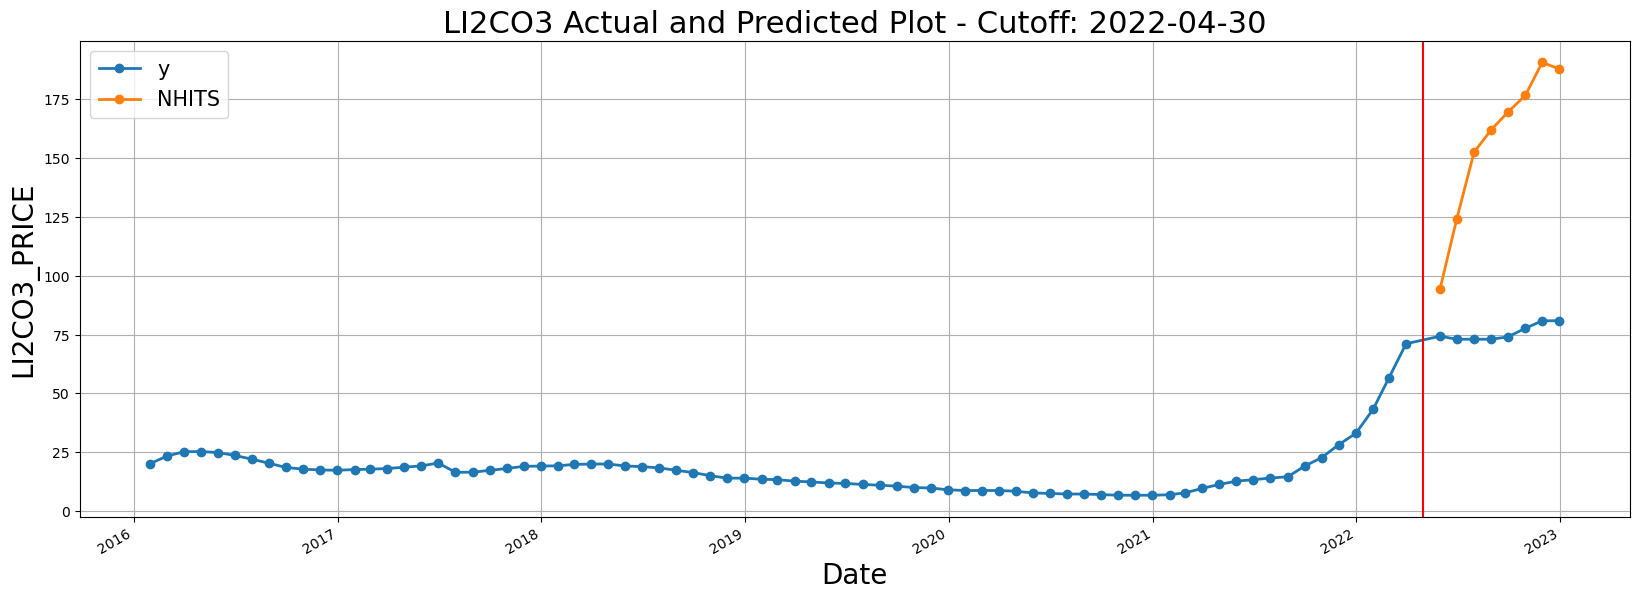

In [56]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [57]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)